In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from scipy.io import wavfile
import warnings
import os
import zipfile
import pandas as pd
from sklearn import preprocessing

warnings.filterwarnings('ignore')

In [3]:
raw_file_path = '/content/drive/MyDrive/language-audio-data.zip'
target_dir = 'final_data'
os.makedirs(target_dir, exist_ok=True)

with zipfile.ZipFile(raw_file_path,"r") as zip_f:
    zip_f.extractall(target_dir)

### Check the number of files in each class

In [4]:
audio_dir1 = os.path.join(target_dir,'language-audio-data')
os.listdir(audio_dir1)

['Telugu', 'Tamil', 'Kannada', 'Hindi']

In [5]:
classes = []
for i in os.listdir(audio_dir1):
    classes.append(i)
    class_path = audio_dir1 + '/' + str(i)
    audio_clips = os.listdir(class_path)
    print(f"No. of .wav files in audio {i} folder = ",len(audio_clips))

No. of .wav files in audio Telugu folder =  2002
No. of .wav files in audio Tamil folder =  2002
No. of .wav files in audio Kannada folder =  2002
No. of .wav files in audio Hindi folder =  2002


### Convert MP3 to wave

In [6]:
# from os import path
# from pydub import AudioSegment

# os.makedirs("final_wav", exist_ok=True)

# for folder in os.listdir(audio_dir1):
#     class_path = audio_dir1 + '/' + str(folder)
#     for count, files in enumerate(os.listdir(class_path)):
#       src = f"{audio_dir1}/{folder}/{files}"
#       file_name = f"{folder}-{str(count)}.wav"
#       dst = f"final_wav/{folder}"W
#       os.makedirs(dst, exist_ok=True)
#       dst = f"final_wav/{folder}/{file_name}"
#       sound = AudioSegment.from_mp3(src)
#       sound.export(dst, format="wav")

### Create Metadata for your dataset

In [7]:
# rename the files

for folder in os.listdir(audio_dir1):
    class_path = audio_dir1 + '/' + str(folder)
    for count, files in enumerate(os.listdir(class_path)):
        try:
            dst = f"{folder}1-{str(count)}.wav"
            src =f"{audio_dir1}/{folder}/{files}"
            dst =f"{audio_dir1}/{folder}/{dst}"
            os.rename(src, dst)
        except FileExistsError:
             pass

In [8]:
### create meta data

wav_dir = '/content/final_data/language-audio-data'

metadata = {}
for label in os.listdir(wav_dir):
    class_path = wav_dir + '/' + str(label)
    audio_clips = os.listdir(class_path)
    for filename in audio_clips:
        metadata[filename] = label

# Create a metadata csv file
metadata = pd.DataFrame.from_dict(metadata, orient='index').reset_index().sort_values(by=0)
metadata.columns = ['filename', 'foldername']
le = preprocessing.LabelEncoder()
metadata['labels'] = le.fit_transform(metadata.foldername)
metadata.to_csv('metadata.csv', index=False)
metadata

,filename,foldername,labels
5016,Hindi1-1264.wav,Hindi,0
4171,Hindi1-1683.wav,Hindi,0
4172,Hindi1-882.wav,Hindi,0
4173,Hindi1-1337.wav,Hindi,0
4174,Hindi1-708.wav,Hindi,0
...,...,...,...
837,Telugu1-1998.wav,Telugu,3
838,Telugu1-1906.wav,Telugu,3
839,Telugu1-1359.wav,Telugu,3
832,Telugu1-1854.wav,Telugu,3


In [9]:
# Check the mappings
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Hindi': 0, 'Kannada': 1, 'Tamil': 2, 'Telugu': 3}


Custom PyTorch Dataset

In [10]:
# import-libraries

import torch
from torch.utils.data import Dataset
import torchaudio
import pandas as pd

In [11]:
class IndianLanguageDataset(Dataset):
  def __init__(self, metadata, audio_dir, target_sample_rate, num_samples, transformation):
    self.annotations = pd.read_csv(metadata)
    self.audio_dir = audio_dir
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples
    self.transformation = transformation

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,idx):
    audio_sample_path = self._get_audio_sample_path(idx)
    label = self._get_audio_sample_label(idx)
    signal, sr = torchaudio.load(audio_sample_path)
    signal = self.resample_audio(signal, sr)
    signal = self.mix_down_channels(signal)
    signal = self.cut_if_needed(signal)
    signal = self.right_padding(signal)
    signal = self.transformation(signal)
    return signal , label

  def _get_audio_sample_path(self,idx):
    class_name = f"{self.annotations.iloc[idx, 1]}"
    path = os.path.join(self.audio_dir, class_name, self.annotations.iloc[idx, 0])
    return path

  def _get_audio_sample_label(self, idx):
    return self.annotations.iloc[idx, 2]

  def resample_audio(self, signal, sr):
    if sr != self.target_sample_rate:
        resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
        signal = resampler(signal)
    return signal

  def mix_down_channels(self, signal):
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim = 0, keepdim=True)
    return signal

  def cut_if_needed(self, signal):
    if signal.shape[1] > self.num_samples:
        signal = signal[:, :self.num_samples]
    return signal

  def right_padding(self, signal):
    length_signal = signal.shape[1]
    if length_signal < self.num_samples:
        num_missing = self.num_samples - length_signal
        last_dim_padding = (0, num_missing)
        signal = torch.nn.functional.pad(signal, last_dim_padding)
    return signal

In [12]:
# create MEl spectrogram transformations
SAMPLE_RATE = 48000
NUM_SAMPLES = 240000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE)


In [13]:
ild = IndianLanguageDataset(metadata='metadata.csv',
                            audio_dir=wav_dir,
                            target_sample_rate=SAMPLE_RATE,
                            transformation=mel_spectrogram,
                            num_samples= NUM_SAMPLES)
print(f"there are {len(ild)} samples in the dataset")

there are 5017 samples in the dataset


In [14]:
specgram , label = ild[14]

In [15]:
print(f'signal:{specgram.shape} \n label: {label}')

signal:torch.Size([1, 128, 1201]) 
 label: 0


In [16]:
import matplotlib.pyplot as plt
from IPython.display import Audio

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram.squeeze(), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

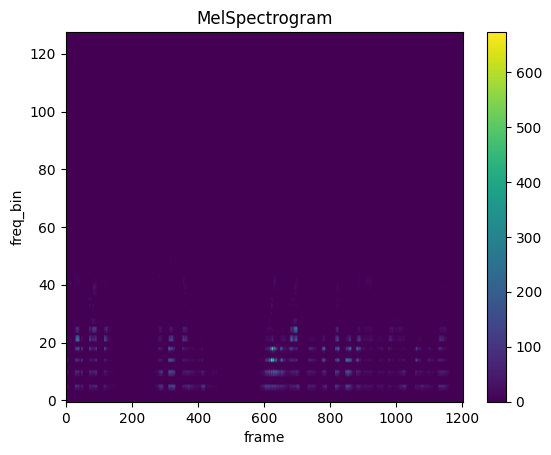

In [17]:
plot_spectrogram(specgram, title='MelSpectrogram')

In [20]:
sample_data, sr = torchaudio.load("/content/final_data/language-audio-data/Hindi/Hindi1-1001.wav")

## CNN MODEL

In [21]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

class ImageClassification(nn.Module):
    def training_step(self, batch):
      images, labels = batch
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss

    def validation_step(self, batch):
      images, labels = batch
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Model Architecture

In [22]:
class CNNNetwork(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = self.conv_block(in_channels, 16, pool=True)
        self.conv2 = self.conv_block(16, 32, pool=True)
        self.conv3 = self.conv_block(32, 64, pool=True)
        self.conv4 = self.conv_block(64, 128, pool=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(128 * 5 * 4, num_classes)
        self.softmax = nn.Softmax(dim=1)

    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=2),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(kernel_size=2))
        return nn.Sequential(*layers)

    def forward(self, input_data):
        out = self.conv1(input_data)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flatten(out)
        out = self.dropout(out)
        logits = self.linear(out)
        predictions = self.softmax(logits)
        return predictions

In [23]:
cnn = CNNNetwork(in_channels = 1, num_classes = 4)

In [24]:
summary(cnn.cuda(), (1,62,40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 42]             160
       BatchNorm2d-2           [-1, 16, 64, 42]              32
              ReLU-3           [-1, 16, 64, 42]               0
         MaxPool2d-4           [-1, 16, 32, 21]               0
            Conv2d-5           [-1, 32, 34, 23]           4,640
       BatchNorm2d-6           [-1, 32, 34, 23]              64
              ReLU-7           [-1, 32, 34, 23]               0
         MaxPool2d-8           [-1, 32, 17, 11]               0
            Conv2d-9           [-1, 64, 19, 13]          18,496
      BatchNorm2d-10           [-1, 64, 19, 13]             128
             ReLU-11           [-1, 64, 19, 13]               0
        MaxPool2d-12             [-1, 64, 9, 6]               0
           Conv2d-13           [-1, 128, 11, 8]          73,856
      BatchNorm2d-14           [-1, 128

GPU Functions

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class GPUDataLoader():
    """Wrap a pytorch Dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Training Function

In [26]:
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def fit(model, train_loader, val_loader, epochs, lr, opt_func):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  scheduler = StepLR(optimizer= optimizer,
                  step_size = 3,
                  gamma= 0.1)
  for epoch in range(1, epochs+1):
    #Training
    print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
    train_losses = []
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, batch in loop:
        loss = model.training_step(batch)
        train_losses.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()
        scheduler.step()

        # update progress bar
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(loss = loss.item())

    # validation steps
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

### Make stratified split of data to have same number of samples per each class

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, train_size=0.7, test_size=0.3, random_state=36)
for train_index, test_index in split.split(metadata, metadata['labels']):
    strat_train_set = metadata.loc[train_index]
    strat_val_set = metadata.loc[test_index]

strat_train_set.to_csv('metadata_train.csv', index=False)
strat_val_set.to_csv('metadata_val.csv', index=False)

In [28]:
torch.cuda.get_device_name()

'Tesla T4'

### Move model objects to GPU

In [29]:
BATCH_SIZE = 64

SAMPLE_RATE = 4000
NUM_SAMPLES = 20000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                                  n_fft = 1024,
                                                  hop_length = 512,
                                                  n_mels = 64)
# Adam optimiser
optimser = torch.optim.Adam

train_lang_data = IndianLanguageDataset(metadata='metadata_train.csv',
                                        audio_dir = wav_dir,
                                        target_sample_rate=SAMPLE_RATE,
                                        transformation=mel_spectrogram,
                                        num_samples=NUM_SAMPLES
                                        )
val_lang_data = IndianLanguageDataset(metadata='metadata_val.csv',
                                       audio_dir= wav_dir,
                                       target_sample_rate=SAMPLE_RATE,
                                       transformation=mel_spectrogram,
                                       num_samples=NUM_SAMPLES
                                       )

train_dl = DataLoader(dataset=train_lang_data,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(dataset=val_lang_data,
                      batch_size=BATCH_SIZE*2,
                      num_workers=4,
                      pin_memory=True)

In [30]:
device = get_default_device()
device

device(type='cuda')

In [31]:
# move model to device
model = to_device(CNNNetwork(1, 4), device)

train_dl = GPUDataLoader(train_dl, device)
val_dl = GPUDataLoader(val_dl, device)

## Training the model

In [32]:
evaluate(model, val_dl)

{'val_loss': 1.431897521018982, 'val_acc': 0.2379092425107956}

In [33]:
history = fit(model=model, train_loader=train_dl, val_loader=val_dl, epochs=5, lr=0.01, opt_func=optimser)

Epoch: 1 LR: [0.01]


Epoch [1], train_loss: 1.2874, val_loss: 1.2827, val_acc: 0.4416
Epoch: 2 LR: [1.0000000000000011e-20]


Epoch [2], train_loss: 1.2822, val_loss: 1.2843, val_acc: 0.4377
Epoch: 3 LR: [1.000000000000002e-38]


Epoch [3], train_loss: 1.2818, val_loss: 1.2821, val_acc: 0.4409
Epoch: 4 LR: [1.000000000000003e-57]


Epoch [4], train_loss: 1.2835, val_loss: 1.2833, val_acc: 0.4383
Epoch: 5 LR: [1.0000000000000044e-75]


Epoch [5], train_loss: 1.2807, val_loss: 1.2867, val_acc: 0.4364


In [34]:
torch.save(model.state_dict(), 'model.pt')

In [35]:
## Loading saved model

In [36]:
saved_model = torch.load("model.pt")

In [37]:
model1 = CNNNetwork(1,4)

In [38]:
model1.load_state_dict(saved_model)

<All keys matched successfully>

## Prediction

In [39]:
le_name_mapping

{'Hindi': 0, 'Kannada': 1, 'Tamil': 2, 'Telugu': 3}

In [40]:
torch.device('cpu')

device(type='cpu')

In [41]:
target_input , label = val_lang_data[1000][0], val_lang_data[1000][1]

In [42]:
def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected

In [43]:
predicted, expected = predict(model=model.to(device='cpu'), input= target_input.unsqueeze_(0), target=label, class_mapping=list(le_name_mapping.keys()))

In [44]:
print(f"the model has predicted: {predicted} and the expected class is : {expected}")

the model has predicted: Kannada and the expected class is : Kannada
